# Understanding Bayesian Optimization

A simple worked through example of using BO to find the minimum of a one dimensional function

The majority of this is taken from  *Gaussian processes for machine learning* by C. E. Rasmussen and C. K. I. Williams.


In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

### Target function and input domain

We start by defning the target funtion and generating the input domain, x_true 

Text(0.5,0,u'x')

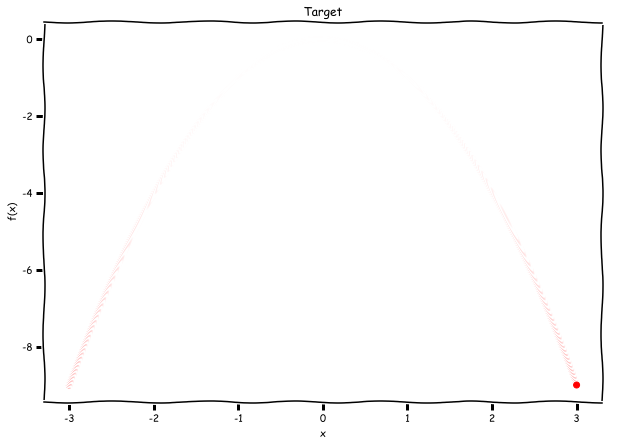

In [248]:
# Define the function we're trying to minimize 
def f(x):
    return -x**2

# define a set of measurmenets
min_x,max_x, n_samples = -3,3,4
# True distirubtuion
X_true =  np.linspace(min_x,max_x,1000) 
f_x_true = [f(x) for x in X_true]

# PSeudo data, we made n_sample measurements
X =  np.linspace(min_x,max_x,n_samples) 
f_x = [f(x) for x in X]

plt.plot(X_true,f_x_true,'ro')
plt.title('Target')
plt.ylabel('f(x)')
plt.xlabel('x')

## Visualizing samples from a Gaussian process

We need to first define a kernel,or covariance, between the a test set of inputs X_test. We are going to first draw a few lines

Then we're going to draw samples of gaussian process given the conditional obserations already made  

In [242]:
def kernel(X,X_prime):
    """
        The covariance or kernel of the gaussian processes used to minimize 
        this example
        
        Sometimes this covariance function is called the Radial Basis Function (RBF) or Gaussian;
        here we prefer squared exponential.
    """
    K =  []
    for i,x in enumerate(X):
        row = []
        for j,x_p in enumerate(X_prime):
            row.append( np.exp( -0.5*np .square( x - x_p )) )
        K.append( row  )
    return np.array(K)

#### Unconditional sampling from Gaussian process

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


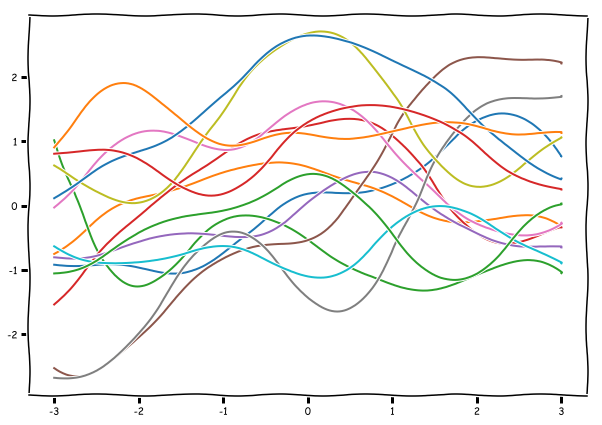

In [243]:
# Geneate the kernal matrix and cahce it so we don't run this costlye process every time 
Sigma =  kernel( X_true,X_true )

for n_examples in xrange(1,15): 
    plt.plot(X_true,np.random.multivariate_normal(np.zeros(len(X_true)), Sigma))
%time

#### Conditional sampling from Gaussian process

We now want to evaluate some postiers, given the 'data' sample X 

In [246]:
def postierier(x,X,f_X):
    """x = x* and X = measured """
    k_xX = kernel(x,X)
    k_XX = kernel(X,X)
    k_XX_inv = np.linalg.inv(k_XX)
    k_xx = kernel(x,x)
    k_Xx = kernel(X,x)
    
    mean = np.matmul(k_XX_inv,f_x )
    mean = np.matmul( k_xX, mean)

    sigma = np.matmul(k_XX_inv, k_Xx)
    sigma = np.matmul(k_xX, sigma)
    sigma = k_xx - sigma
    return mean, sigma

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


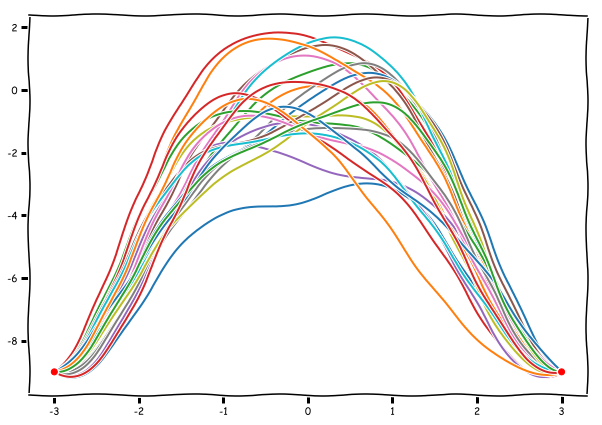

In [245]:
m, s = postierier(X_true, X,f_x ) 
for n_examples in xrange(1,25): 
    plt.plot(X_true,np.random.multivariate_normal(m,s))
plt.plot(X,f_x,'ro')
%time